In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import ranksums
from scipy.stats import ttest_ind

## 데이터 불러오기

In [2]:
df=pd.read_csv('project.csv')

## 1. 데이터 탐색

In [3]:
df

,ELMO2,CREB3L1,RPS11,PNMA1,MMP2,C10orf90,ZHX3,ERCC5,GPR98,RXFP3,...,GRIP2,GPLD1,RAB8A,RXFP2,PIK3IP1,SLC39A6,SNRPD2,AQP7,CTSC,Label
0,0.801250,1.48425,0.059250,-0.00825,1.256000,-2.47700,-0.033167,-0.07000,2.202286,0.7535,...,-0.83775,-0.761800,0.3628,0.6320,1.76825,3.7628,-0.1150,-0.9635,-0.7899,1
1,0.684917,1.55300,0.028250,-0.21000,0.177667,-2.37975,0.407667,-0.42500,-0.233375,0.5675,...,-0.43450,-1.437000,0.1288,0.4420,1.99350,0.8000,-0.3542,-0.6365,-0.7602,1
2,0.460250,0.88750,0.261250,0.44875,-0.318000,-1.69150,-0.618500,0.20100,1.509875,0.2565,...,-0.36800,-1.288667,0.3818,0.2115,1.92200,4.0419,-0.2140,-0.6145,0.3761,1
3,0.428500,2.42650,0.695375,-0.56700,-1.279833,-2.68125,0.176000,0.48325,-0.463500,1.0405,...,-0.38700,-0.830000,-0.0026,1.4125,2.72325,1.5966,-0.2131,0.0435,-1.2608,1
4,0.259917,2.37775,0.298750,-0.07000,0.973000,-2.39800,0.291167,-0.00900,0.204571,0.6030,...,-0.45250,-1.336833,-0.5353,0.4235,0.85125,-1.3794,-0.0078,0.2120,-1.1444,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,0.288000,0.68550,0.928375,0.45100,1.062167,-1.98225,0.437667,-0.15425,0.844250,0.2300,...,-0.28975,-1.460833,0.2360,1.5930,2.02300,2.1548,0.0185,0.1025,-1.1772,1
586,0.156417,0.39325,2.340125,0.48475,0.400000,-1.90425,0.508833,-0.24075,-1.580750,0.2435,...,-0.13875,0.448167,1.0951,-0.3010,2.44500,-0.2443,1.0834,-1.0610,-0.2405,1
587,-0.159636,0.15275,0.150000,-0.09375,-0.880667,-1.69800,-0.473167,0.09750,-1.605875,1.0400,...,-0.28750,-1.308333,0.2499,-0.6300,-0.05825,-1.5545,0.7353,-0.9990,-0.3884,1
588,0.069500,0.13425,0.294375,-0.64900,0.324333,1.09125,-0.566500,1.19450,-1.676250,0.5725,...,-0.11175,0.094500,-0.4834,-0.9165,2.82475,-1.0822,0.0316,-0.5930,0.1481,1


### 1-1) 결측 존재하는 열 확인 후 제거
- 534개 열 제거

In [4]:
df.loc[:,df.isna().sum() > 0].isna().sum().value_counts()

1     212
2      92
3      64
4      44
5      30
6      26
7      18
8      16
10      8
13      8
9       7
14      4
12      2
17      1
16      1
11      1
dtype: int64

In [5]:
df.loc[:,df.isna().sum() > 0].columns

Index(['OR2K2', 'ADAM5P', 'KIAA1486', 'C9orf11', 'C8G', 'OR4C13', 'DEFB125',
       'SEBOX', 'CMA1', 'CCDC60',
       ...
       'MGC32805', 'OR52R1', 'PCDHB1', 'GCG', 'FCER2', 'OR1J4', 'MLNR',
       'SALL3', 'CCDC73', 'RXFP2'],
      dtype='object', length=534)

In [6]:
df.dropna(axis = 1, inplace=True)

In [7]:
X=df.drop(['Label'], axis=1)
y=df['Label']

## 2. 변수 선택
- 정규성을 만족할 수 없으니 Levene's test으로 등분산 검정 진행
- 표본수가 2000 미만이므로 Shapiro_Wilks test으로 정규성 검정진행
- 등분산 및 정규성 만족하는 변수는 Student t-test로 평균비교
- 등분산을 만족하지 않거나, 등분산을 만족하나 정규성을 만족하지 못하는 변수는 wilcoxon rank sum test로 평균비교

### 2-1) Levene's test, Shapiro_Wilks test
- nor_v : 등분산과 정규성 둘다 만족하는 변수들
- notnor_v : 등분산을 만족하지 않거나, 등분산을 만족하나 정규성을 만족하지 못하는 변수들

In [8]:
nor_v=[] 
notnor_v=[]
num_var=list(df.columns)
num_var.remove('Label')
alpha = 0.05

for var in num_var :
    stat0,p0 = levene(df[df['Label']==0][var].dropna(),df[df['Label']==1][var].dropna())
    if p0 > alpha :
        stat1, p1  = shapiro(df[var])
        if p1 > alpha :
            nor_v.append(var)
        else :
            notnor_v.append(var)
    else :
        notnor_v.append(var)

### 2-2) Student t-test, wilcoxon rank sum test
- nor_sig_v : 정규성 따르는 변수 중 평균 차이가 유의한 변수
- nor_notsig_v : 정규성 따르는 변수 중 평균 차이가 유의하지 않은 변수
- notnor_sig_v : 정규성 따르지 않는 변수 중 평균 차이가 유의한 변수
- notnor_notsig_v : 정규성 따르지 않는 변수 중 평균 차이가 유의하지 않은 변수

In [9]:
nor_sig_v=[]
nor_notsig_v=[]
notnor_sig_v=[]
notnor_notsig_v=[]

for var in nor_v :
    stat,p = ttest_ind(df[df['Label']==0][var].dropna(),df[df['Label']==1][var].dropna(), equal_var=True)
    if p < alpha :
        nor_sig_v.append(var)
    else :
        nor_notsig_v.append(var)

for var in notnor_v :
    stat,p = ranksums(df[df['Label']==0][var].dropna(),df[df['Label']==1][var].dropna())
    if p < alpha :
        notnor_sig_v.append(var)
    else :
        notnor_notsig_v.append(var)

In [10]:
print(f'정규성 따르고 평균 차이 유의한 변수 수 : {len(nor_sig_v)}\n정규성 따르나 평균 차이 유의하지 않는 변수 수 : {len(nor_notsig_v)}\n정규성 따르지 않으나 평균 차이 유의한 변수 수 : {len(notnor_sig_v)}\n정규성 따르지 않고 평균 차이도 유의하지 않는 변수 수 : {len(notnor_notsig_v)}')

정규성 따르고 평균 차이 유의한 변수 수 : 874
정규성 따르나 평균 차이 유의하지 않는 변수 수 : 262
정규성 따르지 않으나 평균 차이 유의한 변수 수 : 12182
정규성 따르지 않고 평균 차이도 유의하지 않는 변수 수 : 3962


## 3. Modeling

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## 3-1) 표준화만 한 후 각 모델 비교

In [12]:
X_train , X_test, y_train , y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [13]:
scaler=StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### 3-1-a) Logistic

In [14]:
lr_clf = LogisticRegression(penalty = 'none', solver='saga')
lr_clf.fit(X_train, y_train)

C:\Users\82102\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(penalty='none', solver='saga')

In [15]:
predict = lr_clf.predict(X_test)
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.48      1.00      0.65        16
           1       1.00      0.89      0.94       161

    accuracy                           0.90       177
   macro avg       0.74      0.95      0.80       177
weighted avg       0.95      0.90      0.92       177



### 3-1-b) RandomForest

In [16]:
rfc=RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [17]:
predict = rfc.predict(X_test)
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.99      1.00      1.00       161

    accuracy                           0.99       177
   macro avg       1.00      0.97      0.98       177
weighted avg       0.99      0.99      0.99       177



### 3-1-c) XGboost

In [18]:
xgb=XGBClassifier(random_state=0)
xgb.fit(X_train, y_train)

C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:38:14] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [19]:
predict = xgb.predict(X_test)
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.99      1.00      1.00       161

    accuracy                           0.99       177
   macro avg       1.00      0.97      0.98       177
weighted avg       0.99      0.99      0.99       177



## 4. PCA, ICA

In [20]:
X=df.drop(['Label'], axis=1)

X_nor_sig = X[nor_sig_v]
X_notnor_sig = X[notnor_sig_v]

X_nor_train , X_nor_test, y_train , y_test = train_test_split(X_nor_sig, y, test_size=0.3, random_state=0)
X_notnor_train , X_notnor_test, y_train , y_test = train_test_split(X_notnor_sig, y, test_size=0.3, random_state=0)


scaler1 = StandardScaler()
scaler1.fit(X_nor_train)
X_nor_train = scaler1.transform(X_nor_train)
X_nor_test = scaler1.transform(X_nor_test)

scaler2 = StandardScaler()
scaler2.fit(X_notnor_train)
X_notnor_train = scaler2.transform(X_notnor_train)
X_notnor_test = scaler2.transform(X_notnor_test)

### 4-1) Logistic, 정규성 따르는 것만 PCA

**recall**

C:\Users\82102\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

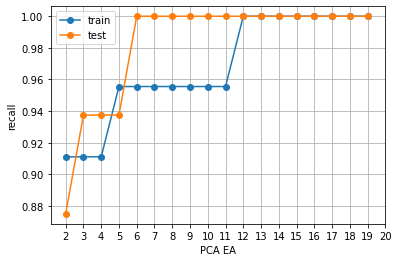

In [21]:
from sklearn.decomposition import PCA

recall_train = []
recall_test = []

dimlist = np.arange(2, 20)

for dim_reduction in dimlist:
    pca = PCA(n_components = dim_reduction)
    pca.fit(X_nor_train)

    Z_train = pca.transform(X_nor_train)
    Z_test = pca.transform(X_nor_test)

    model = LogisticRegression(penalty = 'l1', solver='saga')
    model.fit(Z_train,y_train)

    p_train = model.predict(Z_train)
    p_test = model.predict(Z_test)

    recall_train.append(recall_score(y_train, p_train, pos_label=0))
    recall_test.append(recall_score(y_test, p_test, pos_label=0))    
    
plt.figure()
plt.plot(dimlist, recall_train, 'o-', label='train')
plt.plot(dimlist, recall_test, 'o-', label='test')

plt.xlabel('PCA EA')
plt.ylabel('recall')
start, end =plt.xlim()
plt.xticks(np.arange(2, 21, 1))
plt.legend()
plt.grid()
plt.show()

**Accuracy**

C:\Users\82102\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

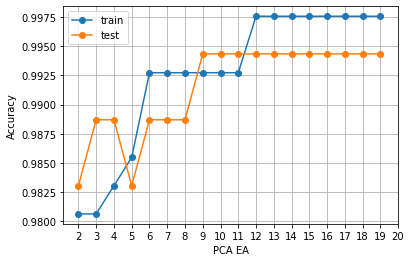

In [22]:
from sklearn.decomposition import PCA

accuracy_train = []
accuracy_test = []

dimlist = np.arange(2, 20)

for dim_reduction in dimlist:
    pca = PCA(n_components = dim_reduction)
    pca.fit(X_nor_train)

    Z_train = pca.transform(X_nor_train)
    Z_test = pca.transform(X_nor_test)

    model = LogisticRegression(penalty = 'l1', solver='saga')
    model.fit(Z_train,y_train)

    p_train = model.predict(Z_train)
    p_test = model.predict(Z_test)

    accuracy_train.append(accuracy_score(y_train, p_train))
    accuracy_test.append(accuracy_score(y_test, p_test))    
    
plt.figure()
plt.plot(dimlist, accuracy_train, 'o-', label='train')
plt.plot(dimlist, accuracy_test, 'o-', label='test')

plt.xlabel('PCA EA')
plt.ylabel('Accuracy')
start, end =plt.xlim()
plt.xticks(np.arange(2, 21, 1))
plt.legend()
plt.grid()
plt.show()

## - 주성분 12개 적절 예상

In [23]:
from pytictoc import TicToc

t = TicToc()

t.tic()

model = LogisticRegression(penalty = 'l1', solver='saga')
model.fit(X_train,y_train)

predict = model.predict(X_test)
print(classification_report(y_test, predict))

t.toc()

              precision    recall  f1-score   support

           0       0.48      1.00      0.65        16
           1       1.00      0.89      0.94       161

    accuracy                           0.90       177
   macro avg       0.74      0.95      0.80       177
weighted avg       0.95      0.90      0.92       177

Elapsed time is 14.534939 seconds.


C:\Users\82102\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [24]:
t = TicToc()

t.tic()

model = LogisticRegression(penalty = 'l1', solver='saga')
model.fit(X_nor_train,y_train)

predict = model.predict(X_nor_test)
print(classification_report(y_test, predict))

t.toc()

              precision    recall  f1-score   support

           0       0.80      1.00      0.89        16
           1       1.00      0.98      0.99       161

    accuracy                           0.98       177
   macro avg       0.90      0.99      0.94       177
weighted avg       0.98      0.98      0.98       177

Elapsed time is 0.483662 seconds.


C:\Users\82102\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [25]:
t = TicToc()

t.tic()

pca = PCA(n_components = 12)
pca.fit(X_nor_train)

Z_train = pca.transform(X_nor_train)
Z_test = pca.transform(X_nor_test)

model = LogisticRegression(penalty = 'l1', solver='saga')
model.fit(Z_train,y_train)

predict = model.predict(Z_test)
print(classification_report(y_test, predict))

t.toc()

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       1.00      0.99      1.00       161

    accuracy                           0.99       177
   macro avg       0.97      1.00      0.98       177
weighted avg       0.99      0.99      0.99       177

Elapsed time is 0.032828 seconds.


C:\Users\82102\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### 4-2) RandomForest

### PCA - RandomForest(정규성 따르는 것들)

### recall

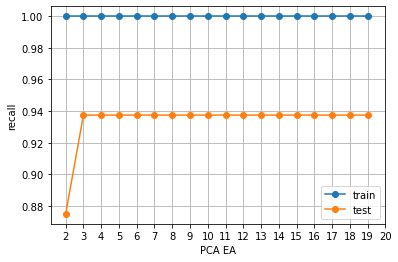

In [26]:
from sklearn.decomposition import PCA

recall_train = []
recall_test = []

dimlist = np.arange(2, 20)

for dim_reduction in dimlist:
    pca = PCA(n_components = dim_reduction)
    pca.fit(X_nor_train)

    Z_train = pca.transform(X_nor_train)
    Z_test = pca.transform(X_nor_test)

    model = RandomForestClassifier(random_state=0)
    model.fit(Z_train,y_train)

    p_train = model.predict(Z_train)
    p_test = model.predict(Z_test)

    recall_train.append(recall_score(y_train, p_train, pos_label = 0))
    recall_test.append(recall_score(y_test, p_test, pos_label = 0))    
    
plt.figure()
plt.plot(dimlist, recall_train, 'o-', label='train')
plt.plot(dimlist, recall_test, 'o-', label='test')

plt.xlabel('PCA EA')
plt.ylabel('recall')
start, end =plt.xlim()
plt.xticks(np.arange(2, 21, 1))
plt.legend()
plt.grid()
plt.show()

### Accuracy

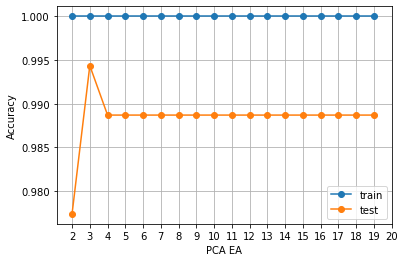

In [27]:
from sklearn.decomposition import PCA

accuracy_train = []
accuracy_test = []

dimlist = np.arange(2, 20)

for dim_reduction in dimlist:
    pca = PCA(n_components = dim_reduction)
    pca.fit(X_nor_train)

    Z_train = pca.transform(X_nor_train)
    Z_test = pca.transform(X_nor_test)

    model = RandomForestClassifier(random_state=0)
    model.fit(Z_train,y_train)

    p_train = model.predict(Z_train)
    p_test = model.predict(Z_test)

    accuracy_train.append(accuracy_score(y_train, p_train))
    accuracy_test.append(accuracy_score(y_test, p_test))    
    
plt.figure()
plt.plot(dimlist, accuracy_train, 'o-', label='train')
plt.plot(dimlist, accuracy_test, 'o-', label='test')

plt.xlabel('PCA EA')
plt.ylabel('Accuracy')
start, end =plt.xlim()
plt.xticks(np.arange(2, 21, 1))
plt.legend()
plt.grid()
plt.show()

## - 주성분 개수 3개로 충분 할 것

### ICA - RandomForest(정규성 안따르는 것)

### recall

C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-pa

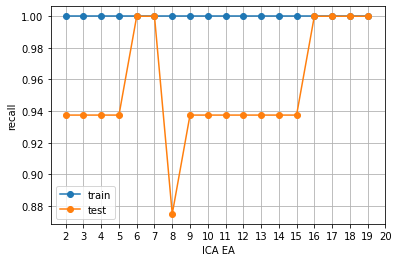

In [28]:
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA

recall_train = []
recall_test = []

dimlist = np.arange(2, 20)

for dim_reduction in dimlist:
    ica = FastICA(n_components = dim_reduction, random_state = 0)
    ica.fit(X_notnor_train)

    Z_train = ica.transform(X_notnor_train)
    Z_test = ica.transform(X_notnor_test)

    model = RandomForestClassifier(random_state=0)
    model.fit(Z_train,y_train)

    p_train = model.predict(Z_train)
    p_test = model.predict(Z_test)

    recall_train.append(recall_score(y_train, p_train, pos_label = 0))
    recall_test.append(recall_score(y_test, p_test, pos_label = 0))    
    
plt.figure()
plt.plot(dimlist, recall_train, 'o-', label='train')
plt.plot(dimlist, recall_test, 'o-', label='test')

plt.xlabel('ICA EA')
plt.ylabel('recall')
start, end =plt.xlim()
plt.xticks(np.arange(2, 21, 1))
plt.legend()
plt.grid()
plt.show()

### Accuracy

C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-pa

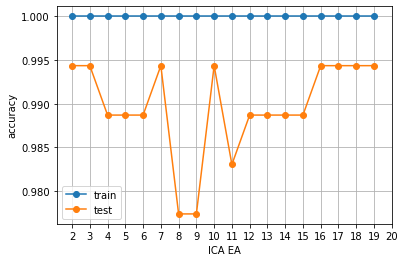

In [29]:
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA

accuracy_train = []
accuracy_test = []

dimlist = np.arange(2, 20)

for dim_reduction in dimlist:
    ica = FastICA(n_components = dim_reduction, random_state = 0)
    ica.fit(X_notnor_train)

    Z_train = ica.transform(X_notnor_train)
    Z_test = ica.transform(X_notnor_test)

    model = RandomForestClassifier(random_state=0)
    model.fit(Z_train,y_train)

    p_train = model.predict(Z_train)
    p_test = model.predict(Z_test)

    accuracy_train.append(accuracy_score(y_train, p_train))
    accuracy_test.append(accuracy_score(y_test, p_test))    
    
plt.figure()
plt.plot(dimlist, accuracy_train, 'o-', label='train')
plt.plot(dimlist, accuracy_test, 'o-', label='test')

plt.xlabel('ICA EA')
plt.ylabel('accuracy')
start, end =plt.xlim()
plt.xticks(np.arange(2, 21, 1))
plt.legend()
plt.grid()
plt.show()

### ICA - 7개로 충분하다고 판단

In [30]:
# 원 변수
t = TicToc()

t.tic()

model = RandomForestClassifier(random_state=0)
model.fit(X_train,y_train)

predict = model.predict(X_test)
print(classification_report(y_test, predict))

t.toc()

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.99      1.00      1.00       161

    accuracy                           0.99       177
   macro avg       1.00      0.97      0.98       177
weighted avg       0.99      0.99      0.99       177

Elapsed time is 1.625587 seconds.


In [32]:
# 주성분 3개 사용
t = TicToc()

t.tic()

pca = PCA(n_components = 3)
pca.fit(X_nor_train)

Z_train = pca.transform(X_nor_train)
Z_test = pca.transform(X_nor_test)

model = RandomForestClassifier(random_state=0)
model.fit(Z_train,y_train)

predict = model.predict(Z_test)
print(classification_report(y_test, predict))

t.toc()

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.99      1.00      1.00       161

    accuracy                           0.99       177
   macro avg       1.00      0.97      0.98       177
weighted avg       0.99      0.99      0.99       177

Elapsed time is 0.158364 seconds.


In [33]:
# 독립성분 7개 사용
t = TicToc()

t.tic()

ica = FastICA(n_components = 7, random_state = 0)
ica.fit(X_notnor_train)

Z_train = ica.transform(X_notnor_train)
Z_test = ica.transform(X_notnor_test)

model = RandomForestClassifier(random_state=0)
model.fit(Z_train,y_train)

predict = model.predict(Z_test)
print(classification_report(y_test, predict))

t.toc()

C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       1.00      0.99      1.00       161

    accuracy                           0.99       177
   macro avg       0.97      1.00      0.98       177
weighted avg       0.99      0.99      0.99       177

Elapsed time is 0.577426 seconds.


In [34]:
#주성분 + 독립성분
t = TicToc()

t.tic()

ica = FastICA(n_components = 7, random_state = 0)
ica.fit(X_notnor_train)

pca = PCA(n_components = 3)
pca.fit(X_nor_train)

pca_train = pca.transform(X_nor_train)
pca_test = pca.transform(X_nor_test)

ica_train = ica.transform(X_notnor_train)
ica_test = ica.transform(X_notnor_test)

Z_train = np.concatenate((pca_train, ica_train), axis=1)
Z_test = np.concatenate((pca_test, ica_test), axis=1)

model = RandomForestClassifier(random_state=0)
model.fit(Z_train,y_train)

predict = model.predict(Z_test)
print(classification_report(y_test, predict))

t.toc()

C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       1.00      0.99      1.00       161

    accuracy                           0.99       177
   macro avg       0.97      1.00      0.98       177
weighted avg       0.99      0.99      0.99       177

Elapsed time is 0.668702 seconds.


### 4-3) XGBoost

### PCA - XGBoost(정규성 따르는 것들)

### recall

[15:39:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:39:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of 

[15:39:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of 

[15:39:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of 

[15:39:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of 

[15:39:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


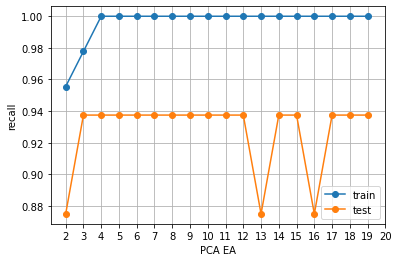

In [35]:
from sklearn.decomposition import PCA

recall_train = []
recall_test = []

dimlist = np.arange(2, 20)

for dim_reduction in dimlist:
    pca = PCA(n_components = dim_reduction)
    pca.fit(X_nor_train)

    Z_train = pca.transform(X_nor_train)
    Z_test = pca.transform(X_nor_test)

    model = XGBClassifier(random_state=0)
    model.fit(Z_train,y_train)

    p_train = model.predict(Z_train)
    p_test = model.predict(Z_test)

    recall_train.append(recall_score(y_train, p_train, pos_label = 0))
    recall_test.append(recall_score(y_test, p_test, pos_label = 0))    
    
plt.figure()
plt.plot(dimlist, recall_train, 'o-', label='train')
plt.plot(dimlist, recall_test, 'o-', label='test')

plt.xlabel('PCA EA')
plt.ylabel('recall')
start, end =plt.xlim()
plt.xticks(np.arange(2, 21, 1))
plt.legend()
plt.grid()
plt.show()

### Accuracy

C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of 

[15:39:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:11] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:11] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:11] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of 

[15:39:11] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:11] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:11] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:11] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of 

[15:39:11] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:11] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:11] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:11] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of 

[15:39:11] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:11] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:12] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


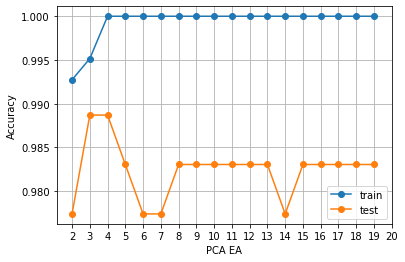

In [36]:
from sklearn.decomposition import PCA

accuracy_train = []
accuracy_test = []

dimlist = np.arange(2, 20)

for dim_reduction in dimlist:
    pca = PCA(n_components = dim_reduction)
    pca.fit(X_nor_train)

    Z_train = pca.transform(X_nor_train)
    Z_test = pca.transform(X_nor_test)

    model = XGBClassifier(random_state=0)
    model.fit(Z_train,y_train)

    p_train = model.predict(Z_train)
    p_test = model.predict(Z_test)

    accuracy_train.append(accuracy_score(y_train, p_train))
    accuracy_test.append(accuracy_score(y_test, p_test))    
    
plt.figure()
plt.plot(dimlist, accuracy_train, 'o-', label='train')
plt.plot(dimlist, accuracy_test, 'o-', label='test')

plt.xlabel('PCA EA')
plt.ylabel('Accuracy')
start, end =plt.xlim()
plt.xticks(np.arange(2, 21, 1))
plt.legend()
plt.grid()
plt.show()

## - 주성분 개수 4개로 충분 할것으로 판단

### ICA - XGBoost(정규성 안따르는 것)

### recall

C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by 

[15:39:12] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[15:39:13] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[15:39:13] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[15:39:14] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[15:39:14] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[15:39:15] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[15:39:15] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[15:39:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[15:39:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[15:39:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[15:39:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[15:39:18] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[15:39:18] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[15:39:19] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[15:39:19] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[15:39:20] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[15:39:20] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:21] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


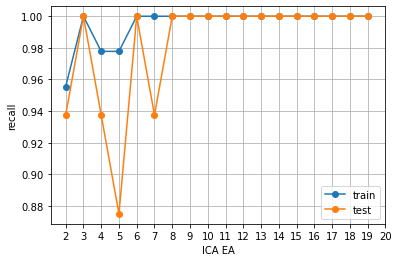

In [37]:
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA

recall_train = []
recall_test = []

dimlist = np.arange(2, 20)

for dim_reduction in dimlist:
    ica = FastICA(n_components = dim_reduction, random_state=0)
    ica.fit(X_notnor_train)

    Z_train = ica.transform(X_notnor_train)
    Z_test = ica.transform(X_notnor_test)

    model = XGBClassifier(random_state=0)
    model.fit(Z_train,y_train)

    p_train = model.predict(Z_train)
    p_test = model.predict(Z_test)

    recall_train.append(recall_score(y_train, p_train, pos_label = 0))
    recall_test.append(recall_score(y_test, p_test, pos_label = 0))    
    
plt.figure()
plt.plot(dimlist, recall_train, 'o-', label='train')
plt.plot(dimlist, recall_test, 'o-', label='test')

plt.xlabel('ICA EA')
plt.ylabel('recall')
start, end =plt.xlim()
plt.xticks(np.arange(2, 21, 1))
plt.legend()
plt.grid()
plt.show()

C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by 

[15:39:21] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[15:39:22] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[15:39:22] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[15:39:23] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[15:39:23] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[15:39:24] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[15:39:24] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[15:39:25] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[15:39:25] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[15:39:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[15:39:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[15:39:27] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[15:39:28] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[15:39:28] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[15:39:29] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[15:39:29] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[15:39:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


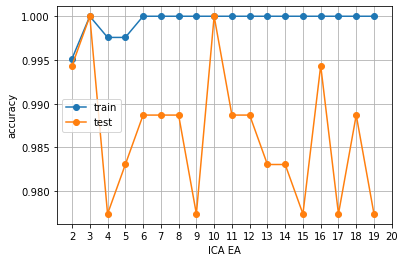

In [38]:
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA

accuracy_train = []
accuracy_test = []

dimlist = np.arange(2, 20)

for dim_reduction in dimlist:
    ica = FastICA(n_components = dim_reduction, random_state = 0)
    ica.fit(X_notnor_train)

    Z_train = ica.transform(X_notnor_train)
    Z_test = ica.transform(X_notnor_test)

    model = XGBClassifier(random_state=0)
    model.fit(Z_train,y_train)

    p_train = model.predict(Z_train)
    p_test = model.predict(Z_test)

    accuracy_train.append(accuracy_score(y_train, p_train))
    accuracy_test.append(accuracy_score(y_test, p_test))    
    
plt.figure()
plt.plot(dimlist, accuracy_train, 'o-', label='train')
plt.plot(dimlist, accuracy_test, 'o-', label='test')

plt.xlabel('ICA EA')
plt.ylabel('accuracy')
start, end =plt.xlim()
plt.xticks(np.arange(2, 21, 1))
plt.legend()
plt.grid()
plt.show()

### ICA - 3개로 충분하다고 판단

In [39]:
# 원 변수
t = TicToc()

t.tic()

model = XGBClassifier(random_state=0)
model.fit(X_train,y_train)

predict = model.predict(X_test)
print(classification_report(y_test, predict))

t.toc()

C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:39:31] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.99      1.00      1.00       161

    accuracy                           0.99       177
   macro avg       1.00      0.97      0.98       177
weighted avg       0.99      0.99      0.99       177

Elapsed time is 4.271164 seconds.


In [40]:
# 주성분 4개 사용
t = TicToc()

t.tic()

pca = PCA(n_components = 4)
pca.fit(X_nor_train)

Z_train = pca.transform(X_nor_train)
Z_test = pca.transform(X_nor_test)

model = XGBClassifier(random_state=0)
model.fit(Z_train,y_train)

predict = model.predict(Z_test)
print(classification_report(y_test, predict))

t.toc()

[15:39:35] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.99      0.99      0.99       161

    accuracy                           0.99       177
   macro avg       0.97      0.97      0.97       177
weighted avg       0.99      0.99      0.99       177

Elapsed time is 0.068520 seconds.


C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [41]:
# 독립성분 3개 사용
t = TicToc()

t.tic()

ica = FastICA(n_components = 3)
ica.fit(X_notnor_train)

Z_train = ica.transform(X_notnor_train)
Z_test = ica.transform(X_notnor_test)

model = XGBClassifier(random_state=0)
model.fit(Z_train,y_train)

predict = model.predict(Z_test)
print(classification_report(y_test, predict))

t.toc()

C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[15:39:35] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.99      1.00      1.00       161

    accuracy                           0.99       177
   macro avg       1.00      0.97      0.98       177
weighted avg       0.99      0.99      0.99       177

Elapsed time is 0.517424 seconds.


C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [42]:
#주성분 + 독립성분
t = TicToc()

t.tic()

ica = FastICA(n_components = 3)
ica.fit(X_notnor_train)

pca = PCA(n_components = 4)
pca.fit(X_nor_train)

pca_train = pca.transform(X_nor_train)
pca_test = pca.transform(X_nor_test)

ica_train = ica.transform(X_notnor_train)
ica_test = ica.transform(X_notnor_test)

Z_train = np.concatenate((pca_train, ica_train), axis=1)
Z_test = np.concatenate((pca_test, ica_test), axis=1)

model = XGBClassifier(random_state=0)
model.fit(Z_train,y_train)

predict = model.predict(Z_test)
print(classification_report(y_test, predict))

t.toc()

C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


[15:39:36] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.99      0.99      0.99       161

    accuracy                           0.99       177
   macro avg       0.97      0.97      0.97       177
weighted avg       0.99      0.99      0.99       177

Elapsed time is 0.500155 seconds.


C:\Users\82102\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


## 5. Kmeans

### 주성분, 독립성분 설명력

In [43]:
dimlist = np.arange(2, 20)

for dim_reduction in dimlist:
    pca = PCA(n_components = dim_reduction)
    pca.fit(X_nor_train)
    
    print(f'주성분 개수 : {dim_reduction}\n설명력 : {round(sum(pca.explained_variance_ratio_),4)}\n')
    


주성분 개수 : 2
설명력 : 0.1927

주성분 개수 : 3
설명력 : 0.2499

주성분 개수 : 4
설명력 : 0.2992

주성분 개수 : 5
설명력 : 0.3472

주성분 개수 : 6
설명력 : 0.3859

주성분 개수 : 7
설명력 : 0.4144

주성분 개수 : 8
설명력 : 0.4364

주성분 개수 : 9
설명력 : 0.4556

주성분 개수 : 10
설명력 : 0.4735

주성분 개수 : 11
설명력 : 0.4897

주성분 개수 : 12
설명력 : 0.5041

주성분 개수 : 13
설명력 : 0.5168

주성분 개수 : 14
설명력 : 0.5285

주성분 개수 : 15
설명력 : 0.539

주성분 개수 : 16
설명력 : 0.549

주성분 개수 : 17
설명력 : 0.559

주성분 개수 : 18
설명력 : 0.568

주성분 개수 : 19
설명력 : 0.5769



In [44]:
scaler1 = StandardScaler()
scaler1.fit(X_nor_sig)
X_nor_sig_k = scaler1.transform(X_nor_sig)

scaler2 = StandardScaler()
scaler2.fit(X_notnor_sig)
X_notnor_sig_k = scaler2.transform(X_notnor_sig)

In [45]:
from matplotlib import cm
from sklearn.metrics import silhouette_samples

## 주성분, 독립성분 각각 3개씩

In [46]:
pca = PCA(n_components = 3)
pca.fit(X_nor_sig_k)
pca_pred = pd.DataFrame(pca.transform(X_nor_sig_k))

ica = FastICA(n_components = 3, random_state = 0)
ica.fit(X_notnor_sig_k)
ica_pred = pd.DataFrame(ica.transform(X_notnor_sig_k))

com_pred = pd.concat([pca_pred, ica_pred, df['Label']], axis = 1)

C:\Users\82102\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


In [47]:
com_pred.columns=['PCA1','PCA2','PCA3','ICA1','ICA2','ICA3','Label']

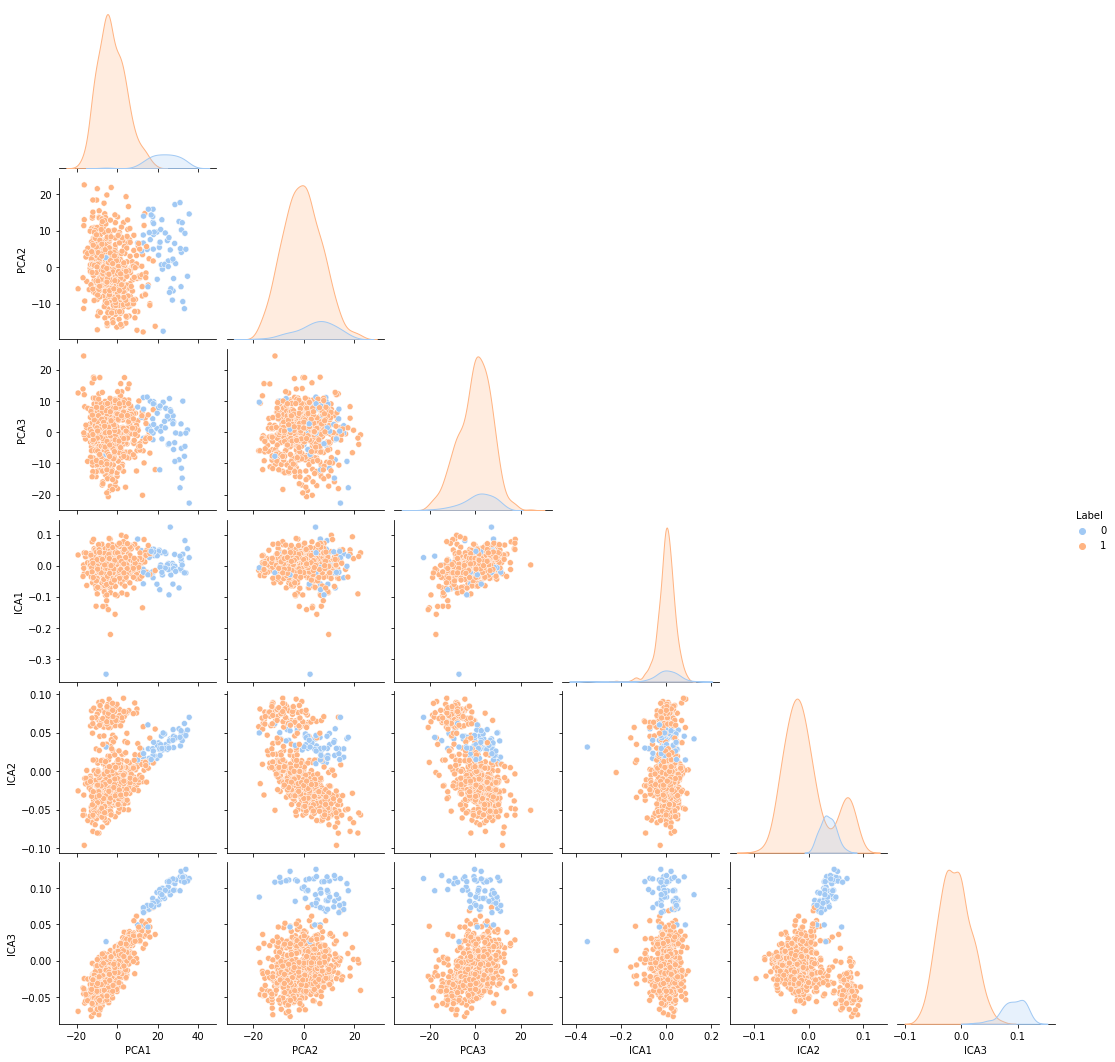

In [48]:
sns.pairplot(com_pred, hue = 'Label',corner=True, palette = 'pastel')

### Elbow Plot

C:\Users\82102\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

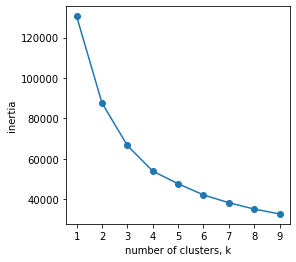

In [49]:
from sklearn.cluster import KMeans
# 적절한 군집수 찾기
# Inertia(군집 내 거리제곱합의 합) value (적정 군집수)

ks = range(1,10)
inertias = []
k_x = com_pred.drop(['Label'], axis = 1)
k_y = com_pred['Label']

for k in ks:
    model = KMeans(n_clusters=k, random_state = 0)
    model.fit(k_x)
    inertias.append(model.inertia_)

# Plot ks vs inertias
plt.figure(figsize=(4, 4))

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

C:\Users\82102\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\82102\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


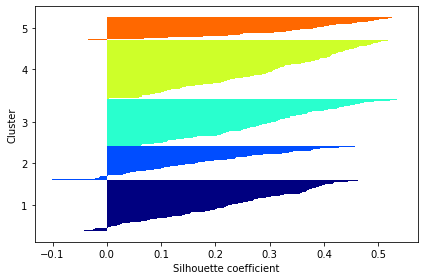

In [50]:
k_x = com_pred.drop(['Label'], axis = 1)
k_y = com_pred['Label']

km = KMeans(n_clusters = 5, random_state = 0)
y_km = km.fit_predict(k_x)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]

# 실루엣 분석
silhouette_vals = silhouette_samples(k_x, y_km, metric = 'euclidean')


# 시각화
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels) :
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height = 1.0,
             edgecolor = 'none', color = color)
    
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
plt.show()

In [52]:
clust_df = com_pred.copy()
clust_df['clust'] = y_km

clust=pd.DataFrame(clust_df.groupby(['clust','Label'])['Label'].count())

clust

Label
clust Label       
0     0          4
      1        138
1     0          1
      1         91
2     1        130
3     1        163
4     0         56
      1          7

<AxesSubplot:xlabel='clust', ylabel='count'>

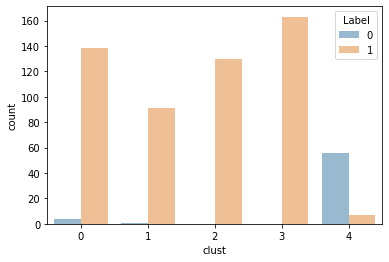

In [53]:
sns.countplot(x='clust', hue='Label', data=clust_df, alpha=0.5)

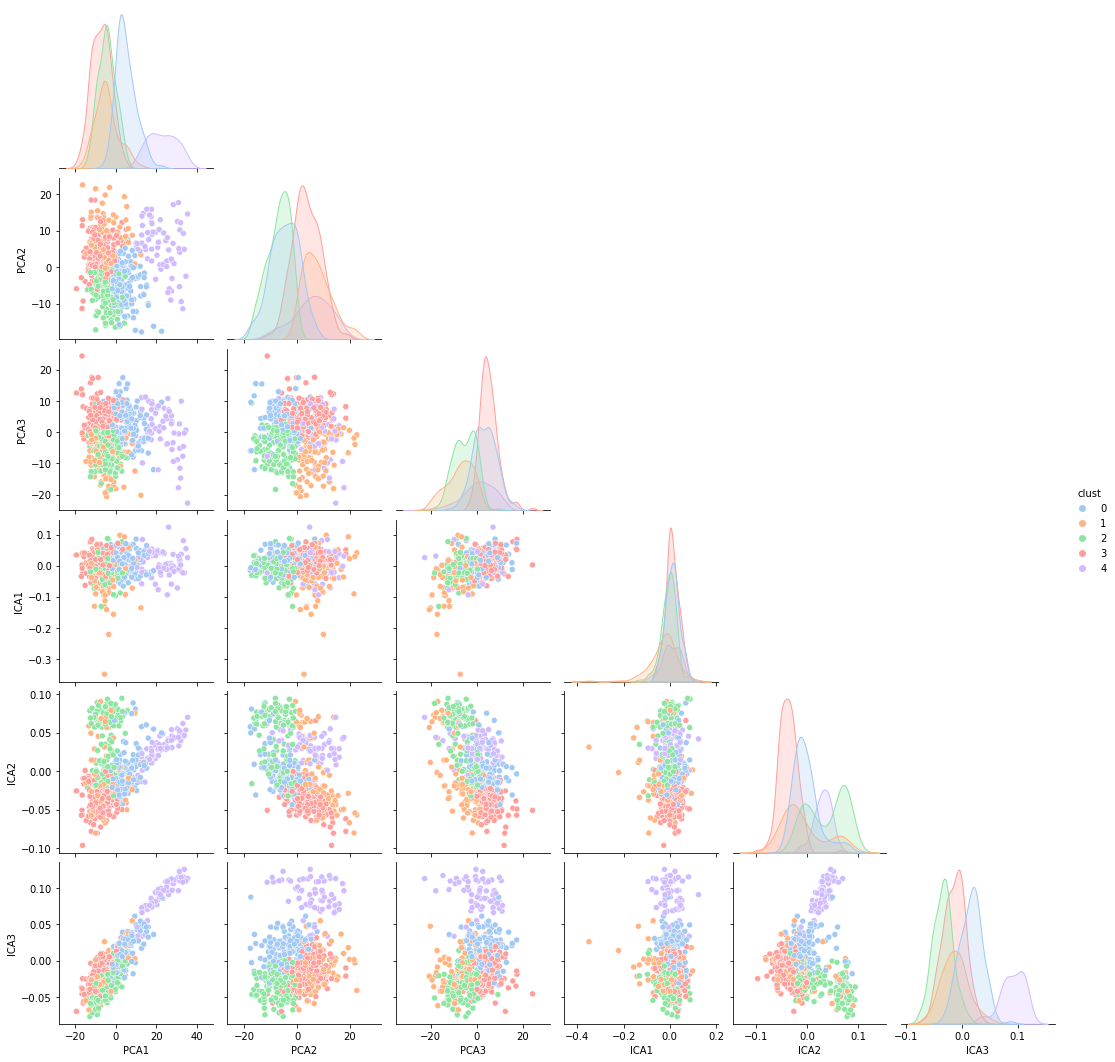

In [54]:
sns.pairplot(clust_df.drop(['Label'], axis=1), hue = 'clust', corner=True, palette = 'pastel')

In [56]:
clust_df.groupby('clust').mean()

,PCA1,PCA2,PCA3,ICA1,ICA2,ICA3,Label
clust,,,,,,,
0,4.976258,-4.760566,3.371702,0.010116,-0.002098,0.016133,0.971831
1,-4.484923,7.561887,-7.397166,-0.029809,-0.006675,-0.012915,0.989130
2,-4.364155,-7.132243,-5.255312,-0.005737,0.038497,-0.034457,1.000000
3,-7.183423,3.425583,5.232596,0.009539,-0.037081,-0.014313,1.000000
4,22.924166,5.541722,0.508494,0.007885,0.030979,0.090631,0.111111


In [68]:
final = pd.concat([clust_df[['PCA1']],X[nor_sig_v]], axis=1)

In [74]:
pd.set_option('display.max_rows',None)
pd.DataFrame(abs(final.corr()['PCA1']).sort_values(ascending=False))

,PCA1
PCA1,1.000000
ECM2,0.762121
EBF3,0.749919
CCNF,0.748439
CUGBP2,0.731100
SPARCL1,0.722574
CLIC2,0.712368
C10orf56,0.708374
PCDH18,0.707545
LAMC1,0.698777


In [75]:
pd.options.display.max_rows = 60
pd.options.display.max_columns = 20